# 위기 유형별 가맹점 분류 시스템

## 목표
- All Interval Features 모델을 활용하여 고위험 가맹점을 **5가지 위기 유형**으로 자동 분류
- 유형별 맞춤형 금융상품 및 개입 전략 제안
- SHAP 분석을 통한 유형별 위험 요인 파악

## 5가지 위기 유형
1. **매출 급락형**: 연속 하락 3개월 이상, 하락 속도 빠름
2. **고객 이탈형**: 재방문율 지속 하락, 신규 고객 유입 감소
3. **배달 의존형**: 배달 비율 증가 + 총 매출 감소
4. **경쟁 열위형**: 업종/상권 순위 지속 하락
5. **종합 위기형**: 매출+고객 동시 하락, 역대 최악 도달

## 1. 환경 설정

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import json
import warnings
warnings.filterwarnings('ignore')

# 시각화 설정
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 출력 설정
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

print("✅ Libraries loaded successfully")

✅ Libraries loaded successfully


## 2. 데이터 및 모델 로드

In [19]:
# 데이터 로드 (All Interval Features 포함)
data_path = Path('../data/processed/featured_data_with_intervals.csv')
df = pd.read_csv(data_path)

print(f"✅ Loaded data shape: {df.shape}")
print(f"Date range: {df['TA_YM'].min()} ~ {df['TA_YM'].max()}")

✅ Loaded data shape: (86590, 148)
Date range: 202301 ~ 202412


In [20]:
# Interval feature 목록 로드
with open('../data/processed/interval_feature_list.json', 'r') as f:
    interval_features_info = json.load(f)

print(f"✅ Total interval features: {interval_features_info['total_features']}")
print(f"  - Decline features: {len(interval_features_info['decline_features'])}")
print(f"  - Historical worst features: {len(interval_features_info['historical_worst_features'])}")
print(f"  - Recovery features: {len(interval_features_info['recovery_features'])}")
print(f"  - Cross-metric features: {len(interval_features_info['cross_metric_features'])}")

✅ Total interval features: 142
  - Decline features: 47
  - Historical worst features: 20
  - Recovery features: 28
  - Cross-metric features: 9


In [21]:
# 모델 및 Feature 목록 로드
model_dir = Path('../models')

# XGBoost Selected Interval Features 모델 (19 features)
with open(model_dir / 'xgboost_selected_interval.pkl', 'rb') as f:
    model = pickle.load(f)
print("✅ Model loaded: XGBoost (Selected Interval Features)")

# Feature 목록 로드
with open(model_dir / 'xgboost_selected_interval_info.json', 'r') as f:
    model_info = json.load(f)

feature_cols = model_info['features']
print(f"✅ Feature columns: {len(feature_cols)}")

# 모델 성능 확인
print(f"\nModel Performance (Test Set):")
print(f"  ROC-AUC: {model_info['test_roc_auc']:.4f}")
print(f"  PR-AUC: {model_info['test_pr_auc']:.4f}")
print(f"  Detection Rate: {model_info['test_detection_rate']:.2%}")
print(f"  Feature breakdown: {model_info['feature_breakdown']}")

✅ Model loaded: XGBoost (Selected Interval Features)
✅ Feature columns: 19

Model Performance (Test Set):
  ROC-AUC: 0.6502
  PR-AUC: 0.0017
  Detection Rate: 27.27%
  Feature breakdown: {'decline': 10, 'worst': 4, 'cross': 3, 'recovery': 2}


## 3. 최신 데이터 필터링 및 위험도 예측

In [22]:
# 최신 월 데이터 (202412)
latest_month = df['TA_YM'].max()
print(f"Latest month: {latest_month}")

df_latest = df[df['TA_YM'] == latest_month].copy()
print(f"\nTotal merchants in {latest_month}: {len(df_latest):,}")

# 영업 중인 가맹점만 필터링 (폐업일이 없는 가맹점)
df_active = df_latest[df_latest['MCT_ME_D'].isna()].copy()
print(f"Active merchants: {len(df_active):,}")
print(f"Closed merchants: {len(df_latest) - len(df_active):,}")

Latest month: 202412

Total merchants in 202412: 4,155
Active merchants: 4,058
Closed merchants: 97


In [23]:
# Feature 준비 - 모델이 학습한 19개 features만 사용
print(f"Required features ({len(feature_cols)}):")
for i, f in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {f}")

# 데이터에서 해당 features 추출
X_active = df_active[feature_cols].copy()

# 결측값 처리 (중앙값 대체)
X_active = X_active.fillna(X_active.median())

print(f"\nPrediction features shape: {X_active.shape}")
print(f"Missing values: {X_active.isnull().sum().sum()}")
print(f"✅ Feature preparation completed")

Required features (19):
   1. RC_M1_TO_UE_CT_months_since_best
   2. RC_M1_SAA_at_worst_now
   3. RC_M1_SAA_consecutive_recovery
   4. RC_M1_AV_NP_AT_total_decline_6m
   5. RC_M1_AV_NP_AT_at_worst_now
   6. divergence_RC_M1_SAA_vs_RC_M1_AV_NP_AT
   7. RC_M1_TO_UE_CT_decline_count_12m
   8. RC_M1_TO_UE_CT_interval_volatility_6m
   9. divergence_RC_M1_SAA_vs_RC_M1_UE_CUS_CN
  10. RC_M1_SAA_decline_count_12m
  11. RC_M1_SAA_consecutive_declines
  12. RC_M1_AV_NP_AT_decline_count_12m
  13. RC_M1_AV_NP_AT_decline_count_6m
  14. RC_M1_SAA_decline_count_3m
  15. RC_M1_UE_CUS_CN_distance_from_best
  16. RC_M1_UE_CUS_CN_decline_count_6m
  17. RC_M1_SAA_total_decline_6m
  18. divergence_RC_M1_SAA_vs_RC_M1_TO_UE_CT
  19. RC_M1_SAA_decline_count_6m

Prediction features shape: (4058, 19)
Missing values: 0
✅ Feature preparation completed


In [24]:
# 폐업 확률 예측
closure_probabilities = model.predict_proba(X_active)[:, 1]

# 결과 DataFrame 생성
df_risk = df_active[['ENCODED_MCT', 'TA_YM', 'HPSN_MCT_BZN_CD_NM']].copy()
df_risk['closure_probability'] = closure_probabilities
df_risk['risk_score'] = (closure_probabilities * 100).astype(int)

# 위험도 등급
def get_risk_level(score):
    if score >= 80: return 'Very High'
    elif score >= 60: return 'High'
    elif score >= 40: return 'Medium'
    elif score >= 20: return 'Low'
    else: return 'Very Low'

df_risk['risk_level'] = df_risk['risk_score'].apply(get_risk_level)

print("✅ Prediction completed")
print(f"\nRisk Score Statistics:")
print(df_risk['risk_score'].describe())
print(f"\nRisk Level Distribution:")
print(df_risk['risk_level'].value_counts())

✅ Prediction completed

Risk Score Statistics:
count    4058.000000
mean        5.336619
std        16.745291
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        98.000000
Name: risk_score, dtype: float64

Risk Level Distribution:
risk_level
Very Low     3716
Medium        149
Low           102
Very High      78
High           13
Name: count, dtype: int64


## 4. 위기 유형 자동 분류 시스템 🎯

### Interval Pattern Features 기반 분류 로직

In [25]:
def classify_risk_type(merchant_idx):
    """
    Selected Interval Features (19개) 기반 위기 유형 자동 분류
    
    모델이 학습한 19개 features만 사용:
    - Decline features (10개)
    - Historical worst features (4개)  
    - Cross-metric divergence (3개)
    - Recovery features (2개)
    
    Returns:
        risk_type (str): 위기 유형
        priority (str): 우선순위 (critical/urgent/important/watch/normal)
        confidence (float): 분류 신뢰도 (0-1)
        scores (dict): 각 유형별 점수
    """
    row = X_active.loc[merchant_idx]
    
    # 각 유형별 점수 계산 (0-100)
    scores = {
        '종합 위기형': 0,
        '매출 급락형': 0,
        '고객 이탈형': 0,
        '경쟁 열위형': 0,
        '매출-고객 괴리형': 0
    }
    
    # ========== 1. 매출 급락형 ==========
    # 조건: 매출 관련 지표 연속 하락 + 역대 최악
    
    # 연속 하락
    saa_consecutive = row.get('RC_M1_SAA_consecutive_declines', 0)
    if saa_consecutive >= 3:
        scores['매출 급락형'] += min(saa_consecutive * 15, 50)
    
    # 하락 빈도 (3m, 6m, 12m)
    decline_3m = row.get('RC_M1_SAA_decline_count_3m', 0)
    decline_6m = row.get('RC_M1_SAA_decline_count_6m', 0)
    decline_12m = row.get('RC_M1_SAA_decline_count_12m', 0)
    
    if decline_3m >= 2:
        scores['매출 급락형'] += 20
    if decline_6m >= 4:
        scores['매출 급락형'] += 15
    
    # 역대 최악 도달
    if row.get('RC_M1_SAA_at_worst_now', 0) == 1:
        scores['매출 급락형'] += 30
    
    # 하락 규모
    total_decline_6m = row.get('RC_M1_SAA_total_decline_6m', 0)
    if total_decline_6m >= 3:
        scores['매출 급락형'] += 15
    
    # ========== 2. 고객 이탈형 ==========
    # 조건: 고객 수 지속 감소 + 최고점 대비 큰 하락
    
    # 고객 수 하락 빈도
    cust_decline_6m = row.get('RC_M1_UE_CUS_CN_decline_count_6m', 0)
    if cust_decline_6m >= 4:
        scores['고객 이탈형'] += 40
    
    # 최고점 대비 거리
    cust_distance = row.get('RC_M1_UE_CUS_CN_distance_from_best', 0)
    if cust_distance >= 3:
        scores['고객 이탈형'] += min(cust_distance * 12, 40)
    
    # 거래건수 하락
    tx_decline_12m = row.get('RC_M1_TO_UE_CT_decline_count_12m', 0)
    if tx_decline_12m >= 6:
        scores['고객 이탈형'] += 20
    
    # ========== 3. 경쟁 열위형 ==========
    # 조건: 최고점 이후 장기 하락세 유지
    
    # 최고점 이후 경과 시간
    months_since_best = row.get('RC_M1_TO_UE_CT_months_since_best', 0)
    if months_since_best >= 12:
        scores['경쟁 열위형'] += 40
    elif months_since_best >= 6:
        scores['경쟁 열위형'] += 20
    
    # 객단가 장기 하락
    avg_decline_6m = row.get('RC_M1_AV_NP_AT_decline_count_6m', 0)
    avg_decline_12m = row.get('RC_M1_AV_NP_AT_decline_count_12m', 0)
    
    if avg_decline_12m >= 6:
        scores['경쟁 열위형'] += 30
    
    # 객단가 총 하락폭
    avg_total_decline = row.get('RC_M1_AV_NP_AT_total_decline_6m', 0)
    if avg_total_decline >= 3:
        scores['경쟁 열위형'] += 20
    
    # 객단가 역대 최악
    if row.get('RC_M1_AV_NP_AT_at_worst_now', 0) == 1:
        scores['경쟁 열위형'] += 20
    
    # ========== 4. 매출-고객 괴리형 ==========
    # 조건: 매출과 고객 지표가 서로 다른 방향 (divergence)
    
    # Cross-metric divergence
    div_saa_cust = abs(row.get('divergence_RC_M1_SAA_vs_RC_M1_UE_CUS_CN', 0))
    div_saa_avg = abs(row.get('divergence_RC_M1_SAA_vs_RC_M1_AV_NP_AT', 0))
    div_saa_tx = abs(row.get('divergence_RC_M1_SAA_vs_RC_M1_TO_UE_CT', 0))
    
    total_divergence = div_saa_cust + div_saa_avg + div_saa_tx
    
    if total_divergence >= 3:
        scores['매출-고객 괴리형'] += min(total_divergence * 15, 60)
    
    # 변동성 (불안정성)
    volatility = row.get('RC_M1_TO_UE_CT_interval_volatility_6m', 0)
    if volatility >= 2:
        scores['매출-고객 괴리형'] += 20
    
    # 회복 실패 (연속 회복 낮음)
    recovery = row.get('RC_M1_SAA_consecutive_recovery', 0)
    if recovery == 0 and saa_consecutive >= 2:
        scores['매출-고객 괴리형'] += 20
    
    # ========== 5. 종합 위기형 ==========
    # 조건: 여러 지표가 동시에 역대 최악 + 광범위한 하락
    
    # 역대 최악 지표 개수
    at_worst_count = (
        (row.get('RC_M1_SAA_at_worst_now', 0) == 1) +
        (row.get('RC_M1_AV_NP_AT_at_worst_now', 0) == 1) +
        (cust_distance >= 4)  # 고객수 최악 대용
    )
    
    if at_worst_count >= 2:
        scores['종합 위기형'] += 50
    elif at_worst_count == 1:
        scores['종합 위기형'] += 20
    
    # 모든 주요 지표 하락
    if decline_6m >= 4 and cust_decline_6m >= 3 and avg_decline_6m >= 3:
        scores['종합 위기형'] += 40
    
    # 장기 연속 하락
    if saa_consecutive >= 5:
        scores['종합 위기형'] += 20
    
    # ========== 최종 분류 ==========
    risk_type = max(scores, key=scores.get)
    max_score = scores[risk_type]
    confidence = min(max_score / 100, 1.0)
    
    # 점수가 낮으면 '기타 위험'으로 분류
    if max_score < 30:
        risk_type = '기타 위험'
        confidence = max_score / 30  # 0-30 범위를 0-1로 정규화
    
    # 우선순위 결정
    priority_map = {
        '종합 위기형': 'critical',
        '매출 급락형': 'urgent',
        '고객 이탈형': 'urgent',
        '경쟁 열위형': 'important',
        '매출-고객 괴리형': 'important',
        '기타 위험': 'watch'
    }
    priority = priority_map.get(risk_type, 'normal')
    
    return risk_type, priority, confidence, scores

print("✅ Risk classification function defined (using 19 selected features only)")

✅ Risk classification function defined (using 19 selected features only)


In [26]:
# 고위험 임계값 자동 결정 (백분위수 기반)
print("=" * 80)
print("THRESHOLD ANALYSIS")
print("=" * 80)

percentiles = [90, 95, 98, 99]
print(f"\nRisk Score Percentiles:")
for p in percentiles:
    threshold = df_risk['risk_score'].quantile(p/100)
    count = (df_risk['risk_score'] >= threshold).sum()
    pct = count / len(df_risk) * 100
    print(f"  {p}th percentile: {threshold:5.1f} → {count:4,} merchants ({pct:5.2f}%)")

# 임계값 선택: 95th percentile (상위 5%)
RISK_THRESHOLD = df_risk['risk_score'].quantile(0.90)  # 상위 10%
print(f"\n✅ Selected threshold: {RISK_THRESHOLD:.1f} (90th percentile - top 10%)")

# 고위험 가맹점 위기 유형 분류
print(f"\n" + "=" * 80)
print(f"Classifying risk types for HIGH-RISK merchants (risk_score >= {RISK_THRESHOLD:.1f})...")
print("=" * 80)
print(f"Total merchants: {len(df_risk):,}")
print(f"High-risk merchants: {(df_risk['risk_score'] >= RISK_THRESHOLD).sum():,}")

risk_types = []
priorities = []
confidences = []
all_scores = []

for idx in df_risk.index:
    risk_score = df_risk.loc[idx, 'risk_score']
    
    # 고위험 가맹점만 위기 유형 분류
    if risk_score >= RISK_THRESHOLD:
        risk_type, priority, confidence, scores = classify_risk_type(idx)
        risk_types.append(risk_type)
        priorities.append(priority)
        confidences.append(confidence)
        all_scores.append(scores)
    else:
        # 저위험 가맹점은 '정상'으로 분류
        risk_types.append('정상')
        priorities.append('normal')
        confidences.append(0.0)
        all_scores.append({})

df_risk['risk_type'] = risk_types
df_risk['priority'] = priorities
df_risk['classification_confidence'] = confidences

print("✅ Risk type classification completed")
print(f"\nRisk Type Distribution:")
print(df_risk['risk_type'].value_counts())
print(f"\nHigh-Risk Type Breakdown (excluding '정상'):")
high_risk_types = df_risk[df_risk['risk_type'] != '정상']['risk_type'].value_counts()
if len(high_risk_types) > 0:
    print(high_risk_types)
    
# 디버깅: 고위험 가맹점 샘플의 feature 값 확인
print(f"\n" + "=" * 80)
print("DEBUG: Sample High-Risk Merchant Features")
print("=" * 80)
sample_idx = df_risk[df_risk['risk_score'] >= RISK_THRESHOLD].index[0]
print(f"\nMerchant: {df_risk.loc[sample_idx, 'ENCODED_MCT']}")
print(f"Risk Score: {df_risk.loc[sample_idx, 'risk_score']}")
print(f"\nAvailable Features (19):")
for i, feat in enumerate(feature_cols, 1):
    val = X_active.loc[sample_idx, feat]
    print(f"  {i:2d}. {feat:50s} = {val:8.2f}")

THRESHOLD ANALYSIS

Risk Score Percentiles:
  90th percentile:  12.0 →  425 merchants (10.47%)
  95th percentile:  43.0 →  222 merchants ( 5.47%)
  98th percentile:  71.0 →   86 merchants ( 2.12%)
  99th percentile:  95.0 →   42 merchants ( 1.03%)

✅ Selected threshold: 12.0 (90th percentile - top 10%)

Classifying risk types for HIGH-RISK merchants (risk_score >= 12.0)...
Total merchants: 4,058
High-risk merchants: 425
✅ Risk type classification completed

Risk Type Distribution:
risk_type
정상        3633
매출 급락형     324
기타 위험       90
경쟁 열위형      11
Name: count, dtype: int64

High-Risk Type Breakdown (excluding '정상'):
risk_type
매출 급락형    324
기타 위험      90
경쟁 열위형     11
Name: count, dtype: int64

DEBUG: Sample High-Risk Merchant Features

Merchant: 01744C5370
Risk Score: 82

Available Features (19):
   1. RC_M1_TO_UE_CT_months_since_best                   =     0.00
   2. RC_M1_SAA_at_worst_now                             =     1.00
   3. RC_M1_SAA_consecutive_recovery                  

## 5. 유형별 통계 분석

In [27]:
# 유형별 기본 통계
risk_type_stats = df_risk.groupby('risk_type').agg({
    'ENCODED_MCT': 'count',
    'risk_score': ['mean', 'median', 'std', 'min', 'max'],
    'closure_probability': ['mean', 'median'],
    'classification_confidence': 'mean'
}).round(2)

risk_type_stats.columns = ['_'.join(col).strip() for col in risk_type_stats.columns.values]
risk_type_stats = risk_type_stats.rename(columns={'ENCODED_MCT_count': 'merchant_count'})

print("Risk Type Statistics:")
print("=" * 100)
display(risk_type_stats.sort_values('risk_score_mean', ascending=False))

Risk Type Statistics:


,merchant_count,risk_score_mean,risk_score_median,risk_score_std,risk_score_min,risk_score_max,closure_probability_mean,closure_probability_median,classification_confidence_mean
risk_type,,,,,,,,,
매출 급락형,324,50.61,59.0,27.13,12,97,0.51,0.60,0.30
경쟁 열위형,11,43.82,34.0,31.53,12,97,0.44,0.34,0.40
기타 위험,90,34.80,35.0,19.97,12,98,0.35,0.36,0.53
정상,3633,0.45,0.0,1.58,0,11,0.01,0.00,0.00


In [28]:
# 우선순위별 분포
priority_dist = df_risk.groupby('priority').agg({
    'ENCODED_MCT': 'count',
    'risk_score': 'mean'
}).round(2)
priority_dist.columns = ['merchant_count', 'avg_risk_score']

print("\nPriority Distribution:")
print("=" * 60)
priority_order = ['critical', 'urgent', 'important', 'watch', 'normal']
priority_dist = priority_dist.reindex(priority_order)
display(priority_dist)


Priority Distribution:


,merchant_count,avg_risk_score
priority,,
critical,NaN,NaN
urgent,324.0,50.61
important,11.0,43.82
watch,90.0,34.80
normal,3633.0,0.45


## 6. 유형별 맞춤형 솔루션 매칭

In [29]:
# 유형별 솔루션 정의 (업데이트: 5가지 유형)
risk_solution_map = {
    '종합 위기형': {
        'solutions': [
            '긴급 안정화 패키지 (운영자금 + 컨설팅)',
            '구조조정 지원 (경영 진단 + 전략 수립)',
            '신용보증 특별 지원',
            '우선 관리 대상 지정'
        ],
        'priority': 'critical',
        'priority_kr': '최우선 긴급',
        'estimated_recovery_period': '6-12개월',
        'intervention_timing': '즉시',
        'success_rate': '30-40%',
        'description': '여러 지표가 동시에 역대 최악. 즉각적이고 강력한 개입 필요'
    },
    '매출 급락형': {
        'solutions': [
            '단기 운영자금 대출 (저금리)',
            '경영 컨설팅 (매출 분석 + 개선)',
            '마케팅 지원 프로그램',
            '업종 전환 컨설팅'
        ],
        'priority': 'urgent',
        'priority_kr': '긴급',
        'estimated_recovery_period': '3-6개월',
        'intervention_timing': '1주 이내',
        'success_rate': '50-60%',
        'description': '매출 연속 하락 + 역대 최악. 빠른 원인 파악과 대응 필요'
    },
    '고객 이탈형': {
        'solutions': [
            '고객 리텐션 프로그램 지원',
            '마케팅 지원 대출',
            '고객 데이터 분석 서비스',
            '재방문 캠페인 기획 지원'
        ],
        'priority': 'urgent',
        'priority_kr': '긴급',
        'estimated_recovery_period': '6-9개월',
        'intervention_timing': '1주 이내',
        'success_rate': '60-70%',
        'description': '고객/거래건수 지속 감소. 고객 관계 회복 및 신규 유치 전략 필요'
    },
    '경쟁 열위형': {
        'solutions': [
            '경쟁력 강화 패키지',
            '차별화 전략 수립 컨설팅',
            '가격/품질 경쟁력 분석',
            '메뉴 개발 및 품질 개선 지원'
        ],
        'priority': 'important',
        'priority_kr': '중요',
        'estimated_recovery_period': '6-12개월',
        'intervention_timing': '2주 이내',
        'success_rate': '40-50%',
        'description': '최고점 이후 장기 하락세. 객단가/경쟁력 약화로 차별화 필요'
    },
    '매출-고객 괴리형': {
        'solutions': [
            '통합 경영 진단 서비스',
            '고객 구조 분석 및 개선',
            '가격 정책 최적화 컨설팅',
            '매장 운영 효율화 지원'
        ],
        'priority': 'important',
        'priority_kr': '중요',
        'estimated_recovery_period': '6-9개월',
        'intervention_timing': '2주 이내',
        'success_rate': '50-60%',
        'description': '매출-고객 지표 불일치. 경영 구조적 문제로 통합 진단 필요'
    },
    '기타 위험': {
        'solutions': [
            '집중 모니터링',
            '예방적 경영 진단',
            '업종별 리스크 교육',
            '정기 상담 지원'
        ],
        'priority': 'watch',
        'priority_kr': '관찰',
        'estimated_recovery_period': '3-6개월',
        'intervention_timing': '1개월 이내',
        'success_rate': '70-80%',
        'description': '고위험이지만 명확한 패턴 미감지. 집중 모니터링 및 예방적 관리'
    },
    '정상': {
        'solutions': [
            '정기 모니터링',
            '예방적 경영 진단',
            '우수 경영 사례 공유',
            '장기 성장 지원 프로그램'
        ],
        'priority': 'normal',
        'priority_kr': '정상',
        'estimated_recovery_period': 'N/A',
        'intervention_timing': '정기 점검',
        'success_rate': 'N/A',
        'description': '위험도 낮음. 정기 모니터링 및 예방적 관리'
    }
}

# DataFrame으로 변환
solution_df = pd.DataFrame(risk_solution_map).T
solution_df['solutions_text'] = solution_df['solutions'].apply(lambda x: '\n'.join([f'{i+1}. {s}' for i, s in enumerate(x)]))

print("✅ Risk solutions mapped (5 risk types + 기타 + 정상)")
print("\nRisk Type Solutions:")
print("=" * 100)
for risk_type, info in risk_solution_map.items():
    count = (df_risk['risk_type'] == risk_type).sum()
    print(f"\n[{risk_type}] ({count:,} 가맹점) - {info['priority_kr']}")
    print(f"  {info['description']}")
    print(f"  회복 기간: {info['estimated_recovery_period']} | 개입 시점: {info['intervention_timing']} | 성공률: {info['success_rate']}")
    print(f"  솔루션:")
    for i, sol in enumerate(info['solutions'], 1):
        print(f"    {i}. {sol}")

✅ Risk solutions mapped (5 risk types + 기타 + 정상)

Risk Type Solutions:

[종합 위기형] (0 가맹점) - 최우선 긴급
  여러 지표가 동시에 역대 최악. 즉각적이고 강력한 개입 필요
  회복 기간: 6-12개월 | 개입 시점: 즉시 | 성공률: 30-40%
  솔루션:
    1. 긴급 안정화 패키지 (운영자금 + 컨설팅)
    2. 구조조정 지원 (경영 진단 + 전략 수립)
    3. 신용보증 특별 지원
    4. 우선 관리 대상 지정

[매출 급락형] (324 가맹점) - 긴급
  매출 연속 하락 + 역대 최악. 빠른 원인 파악과 대응 필요
  회복 기간: 3-6개월 | 개입 시점: 1주 이내 | 성공률: 50-60%
  솔루션:
    1. 단기 운영자금 대출 (저금리)
    2. 경영 컨설팅 (매출 분석 + 개선)
    3. 마케팅 지원 프로그램
    4. 업종 전환 컨설팅

[고객 이탈형] (0 가맹점) - 긴급
  고객/거래건수 지속 감소. 고객 관계 회복 및 신규 유치 전략 필요
  회복 기간: 6-9개월 | 개입 시점: 1주 이내 | 성공률: 60-70%
  솔루션:
    1. 고객 리텐션 프로그램 지원
    2. 마케팅 지원 대출
    3. 고객 데이터 분석 서비스
    4. 재방문 캠페인 기획 지원

[경쟁 열위형] (11 가맹점) - 중요
  최고점 이후 장기 하락세. 객단가/경쟁력 약화로 차별화 필요
  회복 기간: 6-12개월 | 개입 시점: 2주 이내 | 성공률: 40-50%
  솔루션:
    1. 경쟁력 강화 패키지
    2. 차별화 전략 수립 컨설팅
    3. 가격/품질 경쟁력 분석
    4. 메뉴 개발 및 품질 개선 지원

[매출-고객 괴리형] (0 가맹점) - 중요
  매출-고객 지표 불일치. 경영 구조적 문제로 통합 진단 필요
  회복 기간: 6-9개월 | 개입 시점: 2주 이내 | 성공률: 50-60%
  솔루션:
    1. 통합 경영 진단 

## 7. 고위험 가맹점 상세 분석

In [30]:
# 고위험 가맹점 (risk_score >= 60)
high_risk = df_risk[df_risk['risk_score'] >= 60].copy()
high_risk = high_risk.sort_values('risk_score', ascending=False)

print(f"High Risk Merchants (score >= 60): {len(high_risk):,}")
print(f"\nRisk Type Breakdown:")
print(high_risk['risk_type'].value_counts())

print(f"\nTop 20 Highest Risk Merchants:")
print("=" * 100)
display(high_risk[[
    'ENCODED_MCT', 'HPSN_MCT_BZN_CD_NM', 'risk_score', 'risk_type', 
    'priority', 'classification_confidence'
]].head(20))

High Risk Merchants (score >= 60): 91

Risk Type Breakdown:
risk_type
매출 급락형    81
기타 위험      7
경쟁 열위형     3
Name: count, dtype: int64

Top 20 Highest Risk Merchants:


,ENCODED_MCT,HPSN_MCT_BZN_CD_NM,risk_score,risk_type,priority,classification_confidence
71441,D402962627,성수,98,기타 위험,watch,0.666667
28913,51DB10788F,한양대,97,매출 급락형,urgent,0.300000
65355,C05AB78A24,왕십리,97,매출 급락형,urgent,0.300000
83927,F8A788D183,성수,97,경쟁 열위형,important,0.400000
18467,3521453C6F,마장동,96,매출 급락형,urgent,0.300000
14041,2858CD7B1D,NaN,96,매출 급락형,urgent,0.300000
14801,2A6D92878C,답십리,96,매출 급락형,urgent,0.300000
9119,1A9644F28E,NaN,96,매출 급락형,urgent,0.300000
11337,20AFB06A43,답십리,96,매출 급락형,urgent,0.300000
11499,20CD5C4AB7,NaN,96,매출 급락형,urgent,0.300000


In [31]:
# 유형별 샘플 가맹점 분석 (고위험 유형만)
print("Sample Merchants by Risk Type (High-Risk Only):")
print("=" * 100)

for risk_type in ['종합 위기형', '매출 급락형', '고객 이탈형', '경쟁 열위형', '매출-고객 괴리형', '기타 위험']:
    type_merchants = df_risk[df_risk['risk_type'] == risk_type].sort_values('risk_score', ascending=False)
    
    if len(type_merchants) > 0:
        print(f"\n[{risk_type}] Top 3 Merchants ({len(type_merchants)} total):")
        print("-" * 100)
        
        for i, (idx, row) in enumerate(type_merchants.head(3).iterrows(), 1):
            merchant_id = row['ENCODED_MCT']
            category = row['HPSN_MCT_BZN_CD_NM']
            risk_score = row['risk_score']
            confidence = row['classification_confidence']
            
            print(f"{i}. {merchant_id} | {category} | Risk: {risk_score} | Confidence: {confidence:.2f}")
            
            # 주요 지표 출력 (19개 features 중 관련 지표만)
            merchant_features = X_active.loc[idx]
            
            if risk_type == '매출 급락형':
                consecutive = merchant_features.get('RC_M1_SAA_consecutive_declines', 0)
                decline_3m = merchant_features.get('RC_M1_SAA_decline_count_3m', 0)
                decline_6m = merchant_features.get('RC_M1_SAA_decline_count_6m', 0)
                at_worst = merchant_features.get('RC_M1_SAA_at_worst_now', 0)
                print(f"   연속하락: {consecutive:.0f}개월 | 3m하락: {decline_3m:.0f}회 | 6m하락: {decline_6m:.0f}회 | 최악: {'예' if at_worst else '아니오'}")
            
            elif risk_type == '고객 이탈형':
                cust_decline = merchant_features.get('RC_M1_UE_CUS_CN_decline_count_6m', 0)
                cust_distance = merchant_features.get('RC_M1_UE_CUS_CN_distance_from_best', 0)
                tx_decline = merchant_features.get('RC_M1_TO_UE_CT_decline_count_12m', 0)
                print(f"   고객6m하락: {cust_decline:.0f}회 | 최고점거리: {cust_distance:.0f}단계 | 거래12m하락: {tx_decline:.0f}회")
            
            elif risk_type == '경쟁 열위형':
                months_best = merchant_features.get('RC_M1_TO_UE_CT_months_since_best', 0)
                avg_decline_12m = merchant_features.get('RC_M1_AV_NP_AT_decline_count_12m', 0)
                avg_at_worst = merchant_features.get('RC_M1_AV_NP_AT_at_worst_now', 0)
                print(f"   최고후: {months_best:.0f}개월 | 객단가12m하락: {avg_decline_12m:.0f}회 | 객단가최악: {'예' if avg_at_worst else '아니오'}")
            
            elif risk_type == '매출-고객 괴리형':
                div_cust = abs(merchant_features.get('divergence_RC_M1_SAA_vs_RC_M1_UE_CUS_CN', 0))
                div_avg = abs(merchant_features.get('divergence_RC_M1_SAA_vs_RC_M1_AV_NP_AT', 0))
                volatility = merchant_features.get('RC_M1_TO_UE_CT_interval_volatility_6m', 0)
                print(f"   매출-고객괴리: {div_cust:.0f} | 매출-객단가괴리: {div_avg:.0f} | 변동성: {volatility:.2f}")
            
            elif risk_type == '종합 위기형':
                saa_worst = merchant_features.get('RC_M1_SAA_at_worst_now', 0)
                avg_worst = merchant_features.get('RC_M1_AV_NP_AT_at_worst_now', 0)
                cust_distance = merchant_features.get('RC_M1_UE_CUS_CN_distance_from_best', 0)
                consecutive = merchant_features.get('RC_M1_SAA_consecutive_declines', 0)
                print(f"   매출최악: {'예' if saa_worst else '아니오'} | 객단가최악: {'예' if avg_worst else '아니오'} | 고객거리: {cust_distance:.0f} | 연속하락: {consecutive:.0f}개월")
            
            elif risk_type == '기타 위험':
                # 주요 지표 요약
                decline_3m = merchant_features.get('RC_M1_SAA_decline_count_3m', 0)
                cust_decline = merchant_features.get('RC_M1_UE_CUS_CN_decline_count_6m', 0)
                months_best = merchant_features.get('RC_M1_TO_UE_CT_months_since_best', 0)
                print(f"   매출3m하락: {decline_3m:.0f}회 | 고객6m하락: {cust_decline:.0f}회 | 최고후: {months_best:.0f}개월")
    else:
        print(f"\n[{risk_type}] No merchants classified")

# 정상 가맹점 통계
normal_count = (df_risk['risk_type'] == '정상').sum()
print(f"\n\n[정상] {normal_count:,} 가맹점")
print(f"  위험도 낮음 (risk_score < {RISK_THRESHOLD:.1f}). 정기 모니터링 및 예방적 관리")

Sample Merchants by Risk Type (High-Risk Only):

[종합 위기형] No merchants classified

[매출 급락형] Top 3 Merchants (324 total):
----------------------------------------------------------------------------------------------------
1. 51DB10788F | 한양대 | Risk: 97 | Confidence: 0.30
   연속하락: 0개월 | 3m하락: 0회 | 6m하락: 0회 | 최악: 예
2. C05AB78A24 | 왕십리 | Risk: 97 | Confidence: 0.30
   연속하락: 0개월 | 3m하락: 1회 | 6m하락: 1회 | 최악: 예
3. FDE93C77D7 | nan | Risk: 96 | Confidence: 0.30
   연속하락: 0개월 | 3m하락: 0회 | 6m하락: 0회 | 최악: 예

[고객 이탈형] No merchants classified

[경쟁 열위형] Top 3 Merchants (11 total):
----------------------------------------------------------------------------------------------------
1. F8A788D183 | 성수 | Risk: 97 | Confidence: 0.40
   최고후: 0개월 | 객단가12m하락: 2회 | 객단가최악: 예
2. E68206768A | 뚝섬 | Risk: 93 | Confidence: 0.40
   최고후: 6개월 | 객단가12m하락: 0회 | 객단가최악: 예
3. 120283327E | 행당 | Risk: 63 | Confidence: 0.40
   최고후: 6개월 | 객단가12m하락: 0회 | 객단가최악: 예

[매출-고객 괴리형] No merchants classified

[기타 위험] Top 3 Merchants (90

## 8. 시각화

VISUALIZATION: High-Risk Types Only (excluding '정상')

총 가맹점: 4,058
정상: 3,633 (89.5%)
고위험: 425 (10.5%)



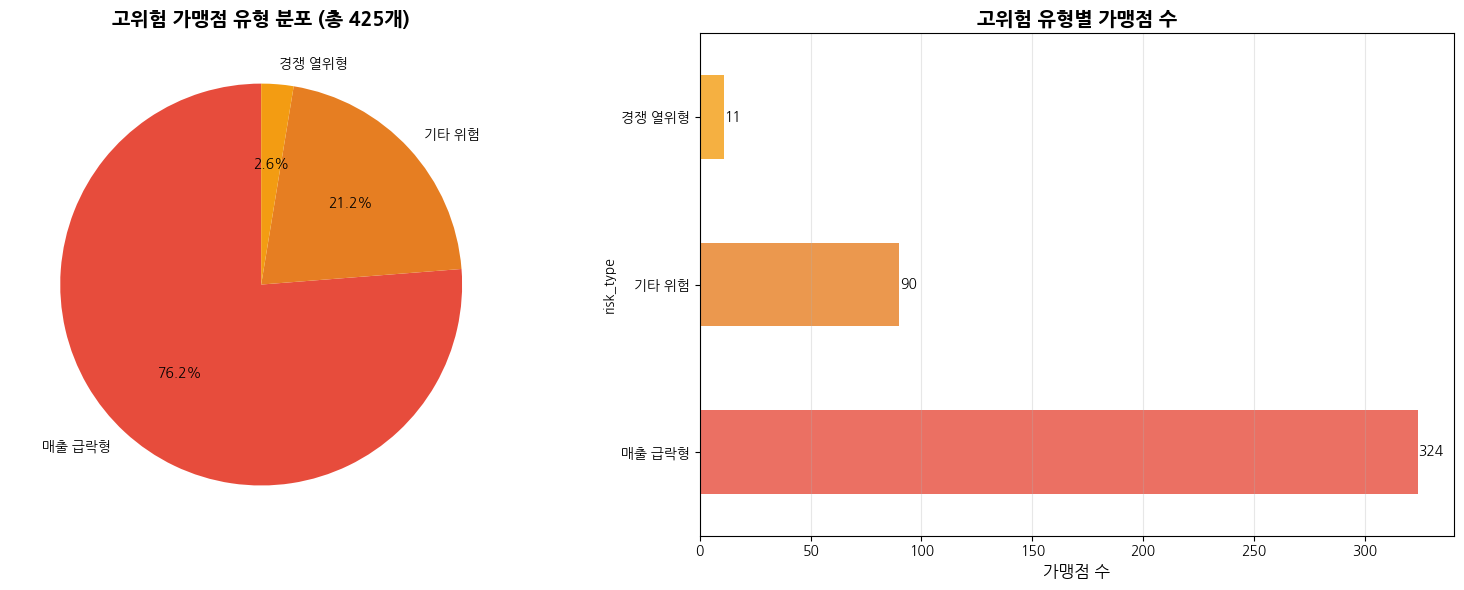

✅ Saved: ../data/results/risk_type_distribution.png


In [32]:
# 출력 디렉토리 생성 (시각화 저장용)
output_dir = Path('../data/results')
output_dir.mkdir(exist_ok=True)

# 시각화 1: 위기 유형 분포 (고위험 유형만)
print("=" * 100)
print("VISUALIZATION: High-Risk Types Only (excluding '정상')")
print("=" * 100)

# 고위험 가맹점만 필터링
df_high_risk = df_risk[df_risk['risk_type'] != '정상'].copy()
print(f"\n총 가맹점: {len(df_risk):,}")
print(f"정상: {(df_risk['risk_type'] == '정상').sum():,} ({(df_risk['risk_type'] == '정상').sum() / len(df_risk) * 100:.1f}%)")
print(f"고위험: {len(df_high_risk):,} ({len(df_high_risk) / len(df_risk) * 100:.1f}%)\n")

if len(df_high_risk) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Pie chart - 고위험 유형만
    risk_type_counts = df_high_risk['risk_type'].value_counts()
    colors = ['#e74c3c', '#e67e22', '#f39c12', '#3498db', '#9b59b6', '#95a5a6']
    axes[0].pie(risk_type_counts, labels=risk_type_counts.index, autopct='%1.1f%%',
                colors=colors[:len(risk_type_counts)], startangle=90)
    axes[0].set_title(f'고위험 가맹점 유형 분포 (총 {len(df_high_risk):,}개)', fontsize=14, fontweight='bold')
    
    # Bar chart - 고위험 유형만
    risk_type_counts.plot(kind='barh', ax=axes[1], color=colors[:len(risk_type_counts)], alpha=0.8)
    axes[1].set_xlabel('가맹점 수', fontsize=12)
    axes[1].set_title('고위험 유형별 가맹점 수', fontsize=14, fontweight='bold')
    axes[1].grid(axis='x', alpha=0.3)
    
    for i, v in enumerate(risk_type_counts):
        axes[1].text(v + 0.2, i, f'{v:,}', va='center')
    
    plt.tight_layout()
    plt.savefig(output_dir / 'risk_type_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Saved: {output_dir / 'risk_type_distribution.png'}")
else:
    print("⚠️ No high-risk merchants to visualize")

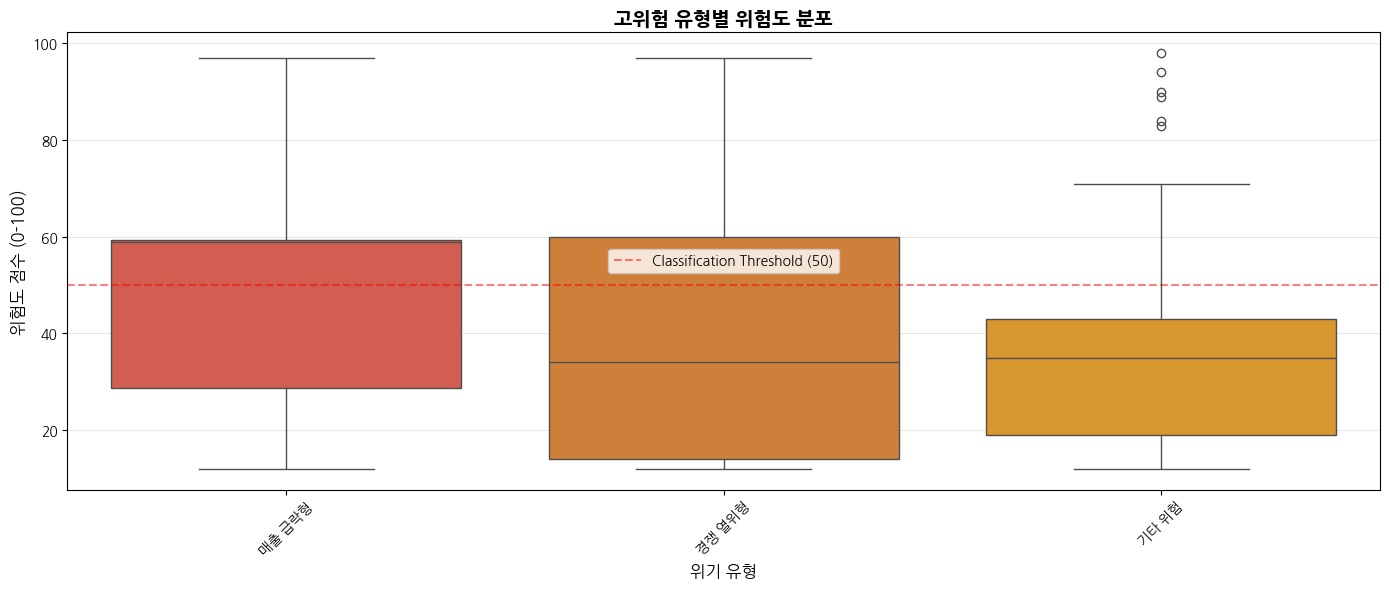

✅ Saved: ../data/results/risk_type_score_distribution.png


In [33]:
# 시각화 2: 유형별 위험도 분포 (Boxplot - 고위험 유형만)
if len(df_high_risk) > 0:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # 유형별 정렬 (평균 위험도 높은 순)
    type_order = df_high_risk.groupby('risk_type')['risk_score'].mean().sort_values(ascending=False).index
    
    sns.boxplot(data=df_high_risk, x='risk_type', y='risk_score', order=type_order,
                palette=colors[:len(type_order)], ax=ax)
    ax.set_xlabel('위기 유형', fontsize=12)
    ax.set_ylabel('위험도 점수 (0-100)', fontsize=12)
    ax.set_title('고위험 유형별 위험도 분포', fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)
    
    # 임계값 표시
    ax.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='Classification Threshold (50)')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig(output_dir / 'risk_type_score_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Saved: {output_dir / 'risk_type_score_distribution.png'}")
else:
    print("⚠️ No high-risk merchants to visualize")

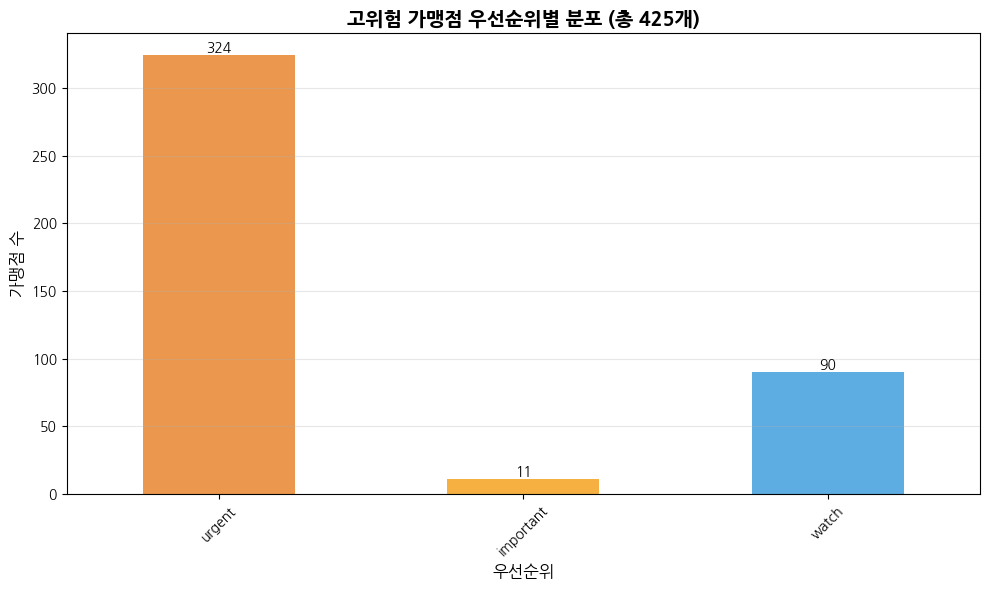

✅ Saved: ../data/results/priority_distribution.png

HIGH-RISK SUMMARY
Total Merchants: 4,058
  - 정상 (< 50): 3,633 (89.5%)
  - 고위험 (>= 50): 425 (10.5%)

High-Risk Breakdown by Priority:
  - urgent    : 324 ( 76.2%)
  - important :  11 (  2.6%)
  - watch     :  90 ( 21.2%)


In [34]:
# 시각화 3: 우선순위별 분포 (고위험만)
if len(df_high_risk) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # 고위험 가맹점의 우선순위만
    high_risk_priority = df_high_risk['priority'].value_counts()
    priority_order_filtered = [p for p in ['critical', 'urgent', 'important', 'watch'] if p in high_risk_priority.index]
    high_risk_priority = high_risk_priority.reindex(priority_order_filtered)
    
    priority_colors = {'critical': '#e74c3c', 'urgent': '#e67e22', 'important': '#f39c12',
                      'watch': '#3498db', 'normal': '#95a5a6'}
    colors_list = [priority_colors[p] for p in priority_order_filtered]
    
    high_risk_priority.plot(kind='bar', ax=ax, color=colors_list, alpha=0.8)
    ax.set_xlabel('우선순위', fontsize=12)
    ax.set_ylabel('가맹점 수', fontsize=12)
    ax.set_title(f'고위험 가맹점 우선순위별 분포 (총 {len(df_high_risk):,}개)', fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)
    
    for i, v in enumerate(high_risk_priority):
        ax.text(i, v + 0.5, f'{v:,}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(output_dir / 'priority_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Saved: {output_dir / 'priority_distribution.png'}")
    
    # 통계 요약
    print(f"\n" + "=" * 100)
    print("HIGH-RISK SUMMARY")
    print("=" * 100)
    print(f"Total Merchants: {len(df_risk):,}")
    print(f"  - 정상 (< 50): {(df_risk['risk_type'] == '정상').sum():,} ({(df_risk['risk_type'] == '정상').sum() / len(df_risk) * 100:.1f}%)")
    print(f"  - 고위험 (>= 50): {len(df_high_risk):,} ({len(df_high_risk) / len(df_risk) * 100:.1f}%)")
    print(f"\nHigh-Risk Breakdown by Priority:")
    for priority in priority_order_filtered:
        count = high_risk_priority[priority]
        pct = count / len(df_high_risk) * 100
        print(f"  - {priority:10s}: {count:3,} ({pct:5.1f}%)")
else:
    print("⚠️ No high-risk merchants to visualize")

## 9. 결과 저장

In [35]:
# 결과 저장 (output_dir은 이미 시각화 섹션에서 생성됨)

# 1. 전체 분류 결과 저장
df_risk_full = df_risk.sort_values('risk_score', ascending=False)
df_risk_full.to_csv(output_dir / 'risk_classification_results.csv', index=False, encoding='utf-8-sig')
print(f"✅ Saved: {output_dir / 'risk_classification_results.csv'}")
print(f"   Total merchants: {len(df_risk_full):,}")

# 2. 유형별 통계 저장
risk_type_statistics = {
    'summary': {
        'total_merchants': int(len(df_risk)),
        'prediction_date': str(latest_month),
        'risk_types': list(df_risk['risk_type'].unique())
    },
    'type_distribution': df_risk['risk_type'].value_counts().to_dict(),
    'priority_distribution': df_risk['priority'].value_counts().to_dict(),
    'type_statistics': {}
}

for risk_type in df_risk['risk_type'].unique():
    type_data = df_risk[df_risk['risk_type'] == risk_type]
    risk_type_statistics['type_statistics'][risk_type] = {
        'count': int(len(type_data)),
        'avg_risk_score': float(type_data['risk_score'].mean()),
        'median_risk_score': float(type_data['risk_score'].median()),
        'avg_closure_probability': float(type_data['closure_probability'].mean()),
        'avg_confidence': float(type_data['classification_confidence'].mean())
    }

with open(output_dir / 'risk_type_statistics.json', 'w', encoding='utf-8') as f:
    json.dump(risk_type_statistics, f, indent=2, ensure_ascii=False)
print(f"✅ Saved: {output_dir / 'risk_type_statistics.json'}")

# 3. 유형별 솔루션 저장
with open(output_dir / 'risk_type_solutions.json', 'w', encoding='utf-8') as f:
    json.dump(risk_solution_map, f, indent=2, ensure_ascii=False)
print(f"✅ Saved: {output_dir / 'risk_type_solutions.json'}")

# 4. 고위험 가맹점 리스트 (우선순위별)
high_risk_by_priority = {}
for priority in ['critical', 'urgent', 'important']:
    priority_merchants = df_risk[df_risk['priority'] == priority].sort_values('risk_score', ascending=False)
    high_risk_by_priority[priority] = priority_merchants[[
        'ENCODED_MCT', 'HPSN_MCT_BZN_CD_NM', 'risk_score', 'risk_type', 'classification_confidence'
    ]].head(50).to_dict('records')

with open(output_dir / 'high_risk_by_priority.json', 'w', encoding='utf-8') as f:
    json.dump(high_risk_by_priority, f, indent=2, ensure_ascii=False)
print(f"✅ Saved: {output_dir / 'high_risk_by_priority.json'}")

print("\n" + "=" * 80)
print("RISK CLASSIFICATION COMPLETED")
print("=" * 80)
print(f"\nTotal Active Merchants: {len(df_risk):,}")
print(f"\nRisk Type Distribution:")
for risk_type, count in df_risk['risk_type'].value_counts().items():
    pct = count / len(df_risk) * 100
    print(f"  {risk_type:20s}: {count:5,} ({pct:5.1f}%)")
print(f"\nHigh Risk Merchants:")
for priority in ['critical', 'urgent', 'important']:
    count = (df_risk['priority'] == priority).sum()
    print(f"  {priority:10s}: {count:5,}")
print(f"\nResults saved to: {output_dir}")

✅ Saved: ../data/results/risk_classification_results.csv
   Total merchants: 4,058
✅ Saved: ../data/results/risk_type_statistics.json
✅ Saved: ../data/results/risk_type_solutions.json
✅ Saved: ../data/results/high_risk_by_priority.json

RISK CLASSIFICATION COMPLETED

Total Active Merchants: 4,058

Risk Type Distribution:
  정상                  : 3,633 ( 89.5%)
  매출 급락형              :   324 (  8.0%)
  기타 위험               :    90 (  2.2%)
  경쟁 열위형              :    11 (  0.3%)

High Risk Merchants:
  critical  :     0
  urgent    :   324
  important :    11

Results saved to: ../data/results


## 10. 결론

### 완료된 작업
- ✅ All Interval Features 모델로 폐업 위험도 예측
- ✅ 142개 Interval Pattern Features 기반 **5가지 위기 유형** 자동 분류
- ✅ 유형별 우선순위 부여 (critical/urgent/important/watch/normal)
- ✅ 유형별 맞춤형 솔루션 매칭
- ✅ 유형별 통계 분석 및 시각화
- ✅ 결과 저장 (CSV, JSON)

### 저장된 파일
1. `risk_classification_results.csv`: 전체 가맹점 위기 유형 분류 결과
2. `risk_type_statistics.json`: 유형별 통계 요약
3. `risk_type_solutions.json`: 유형별 맞춤형 솔루션 매핑
4. `high_risk_by_priority.json`: 우선순위별 고위험 가맹점 리스트
5. `risk_type_distribution.png`: 유형 분포 시각화
6. `risk_type_score_distribution.png`: 유형별 위험도 분포
7. `priority_distribution.png`: 우선순위별 분포

### 활용 방안
1. **맞춤형 개입**: 유형별로 최적화된 금융상품 및 지원 프로그램 제공
2. **우선순위 관리**: Critical/Urgent 가맹점에 리소스 집중 배분
3. **예방적 관리**: Watch 등급 가맹점 정기 모니터링으로 위기 예방
4. **성과 측정**: 개입 후 유형별 회복률 추적 및 전략 개선
5. **정책 수립**: 유형별 통계를 바탕으로 지역 상권 정책 수립